Évaluation de la CFL pour différents couple de schémas espace-temps
===

Nous nous intéressons ici à résoudre au problème :

$$
  \partial_t u + \partial_x f(u) = 0
$$

Dans le cadre de l'étude de la stabilité du schéma, nous nous intéressons uniquement au cas $f'>0$ (dans la pratique on prendra même l'identité, *i.e.* un transport de vitesse 1).

La discrétisation spatiale du problème s'effectue avec le schéma WENO à l'ordre 5. Il s'agit d'un schéma non linéaire, donc la stabilité a déjà été étudié dans le cas linéarisé dans (Wang et Spiteri).

La discrétisation temps s'effectue essentiellement avec un RK3, mais nous allons dans un premier temps vérifier quelques résultats sur différents schémas temporels.

In [5]:
"""
global import, and define symbols
"""

import numpy as np
import matplotlib.pyplot as plt

import sympy as sp
from sympy import I
sp.init_printing(use_latex='mathjax')

phi      = sp.symbols("\\phi",real=True) #,positive=True)
dx,dv,dt = sp.symbols("\\Delta\\ x \\Delta\\ v \\Delta\\ t",real=True,positive=True)
sig      = sp.symbols("\\sigma",real=True,positive=True)
x = sp.symbols("x",real=True)

def reim(b):
  """
    function to split into 2 arrays real part and imaginary part of complex array
  """
  return ([z.real for z in b],[z.imag for z in b])

"""
dummy class to store data
"""
class Data(object):
  pass
data = Data()

# phi array to store angle where evaluate ztilde(phi)
data.phi = np.linspace(0,2.0*np.pi,1000)

# 1. Présentation du schéma WENO

Le schéma WENO nécessite l'évaluation d'*indicator of smoothness* $IS_i$, pour évaluer les poids des 3 estimateurs ENO. N'est présenté ici que le calcul si la fonction $f$ est de dérivée positive

$$
  \begin{aligned}
    IS_0 &= \frac{13}{12}(f_{j-2} - 2f_{j-1} + f_{j}  )^2 + \frac{1}{4}( f_{j-2} - 4f_{j-1} + 3f_{j}  )^2 \\
    IS_1 &= \frac{13}{12}(f_{j-1} - 2f_{j}   + f_{j+1})^2 + \frac{1}{4}( f_{j-1} -  f_{j+1})^2 \\
    IS_2 &= \frac{13}{12}(f_{j}   - 2f_{j+1} + f_{j+2})^2 + \frac{1}{4}(3f_{j}   - 4f_{j+1} +  f_{j+2})^2 \\
  \end{aligned}
$$

On calcule ensuite les poids non normalisés :

$$
    \alpha_i = \frac{\gamma_i}{(\epsilon + IS_i)^2},\quad i=0,1,2
$$

avec $\gamma_0 = \frac{1}{10}$, $\gamma_0 = \frac{6}{10}$ et $\gamma_0 = \frac{3}{10}$.

La normalisation des poids s'effectue comme suit :

$$
    w_i = \frac{\alpha_i}{\sum_m \alpha_m},\quad i=0,1,2
$$

Nous pouvons ensuite calculer les flux numériques pour WENO5 donnés par :

$$
  \begin{aligned}
    \hat{f}_{j+\frac{1}{2}}=\ &  w_0\left( \frac{2}{6}f_{j-2} - \frac{7}{6}f_{j-1} +\frac{11}{6}f_{j}  \right)
                             +   w_1\left(-\frac{1}{6}f_{j-1} + \frac{5}{6}f_{j}   + \frac{2}{6}f_{j+1}\right) \\
                             + & w_2\left( \frac{2}{6}f_{j}   + \frac{5}{6}f_{j+1} - \frac{1}{6}f_{j+2}\right)
  \end{aligned}
$$

La méthode WENO5, pour un transport à vitesse positive, prend la forme finale :

$$
  \frac{\mathrm{d}u_j}{\mathrm{d}t} = -\frac{1}{\Delta x}\left( \hat{f}_{j+\frac{1}{2}} - \hat{f}_{j-\frac{1}{2}} \right)
$$

C'est ceci dont nous allons nous intéresser à la stabilité avec différentes discrétisation en temps.

In [6]:
"""
  fonctions pour l'aide à l'écriture du schéma WENO
"""

def f(k):
  if k==0:
    return sp.symbols("f_j")
  return sp.symbols("f_j%+d"%k)
  
def stencil(i_min,i_max) :
    return dict(enumerate([ f(i) for i in range(i_min,i_max+1) ],start=i_min))
f_stencil = stencil(-3,3)

def symbols_to( stencil , func ):
  """
    symbols_to
    convert dictionary `stencil` of `int => sp.Symbols` to dictionary of `sp.Symbols => sp.Symbols`
    useful to replace all $f_i$ symbols by an other value in expression
  """
  r = {}
  for j,f in stencil.items():
    r[f] = func(j,f)
  return r

def symbols_to_vonNeumann( stencil ):
  """
    symbols_to_vonNeumann
    convert all $f_i$ symbols to equivalent in von Neumann analysis with exponential
    $\phi$ symbol need to be initialized
  """
  return symbols_to( stencil , lambda j,_:sp.exp(I*j*phi) )

Nous allons utiliser l'analyse de von Neumann pour estimer le coefficient d'amplification $\lambda^W(\phi)$ du schéma WENO. L'analyse de von Neumann se basant sur un concept similaire à celui d'une transformée de Fourier, il n'est pas possible de se placer localement en un point de la courbe, nous excitons, selon notre condition initiale, plusieurs modes.

> Il est possible de n'exiter qu'un seul mode si la condition initiale est une simple sinusoïde correspondant à un mode d'excitation particulier. Dans ce cas nous pouvons estimer une CFL propre à cette condition initiale.

Nous allons nous intéresser à 2 courbes de représentation de stabilité du schéma WENO, une première correspondant à la version linéarisée de la méthode (calcul effectué par [Wang R. and Spiteri R. J. (2007)](https://doi.org/10.1137/050637868) ainsi que [Motamed M. and Macdonald C. B. (2010)](https://doi.org/10.1007/s10915-010-9423-9)). Cette linéarisation consiste à approximer les poids (la non linéarité du schéma) par :

$$
  w_i = \gamma_i + \epsilon_i
$$

avec $\epsilon_i = \mathcal{O}(\Delta x^2)$ qui sera par conséquent majoré et négligé par la suite.

Par la suite nous utiliserons la version complète de la méthode WENO, donnant ainsi une seconde courbe.

## 1.1 WENO linéarisé

Le schéma WENO peut se décomposer en une partie linéaire et une partie non linéaire (entièrement guidé par les poids). La fonction $\lambda^W(\phi)$ se décompose comme :

$$
  \lambda^W(\phi) = \tilde{z}(\phi) + M(\{\epsilon_i\}_i,\phi)
$$

Wang et Spiteri montrent qu'il est possible de majorer tranquillement $M$ (partie non linéaire du WENO). Ceci est intéressant pour démontrer la stabilité ou non d'un couple de schéma espace-temps. L'utilisation pour l'évaluation d'une CFL est peut-être un peu plus discutable, cela donne au moins une approximation de celle-ci, facilement calculable.

In [7]:
"""
  linearized WENO method
"""
wenol = Data() # objet qui contiendra les données pour l'analyse numérique du schéma WENO linéarisé

e0,e1,e2 = sp.symbols("\\epsilon_0 \\epsilon_1 \\epsilon_2",real=True)
e3,e4,e5 = sp.symbols("\\epsilon_3 \\epsilon_4 \\epsilon_5",real=True)

w0_l = sp.Rational(1,10) + e0
w1_l = sp.Rational(6,10) + e1
w2_l = sp.Rational(3,10) + e2

w3_l = sp.Rational(1,10) + e3
w4_l = sp.Rational(6,10) + e4
w5_l = sp.Rational(3,10) + e5

fjp12_l = ( w0_l*( sp.Rational(2,6)*f(-2) - sp.Rational(7,6)*f(-1) + sp.Rational(11,6)*f(+0) )
          + w1_l*(-sp.Rational(1,6)*f(-1) + sp.Rational(5,6)*f(+0) +  sp.Rational(2,6)*f(+1) )
          + w2_l*( sp.Rational(2,6)*f(+0) + sp.Rational(5,6)*f(+1) -  sp.Rational(1,6)*f(+2) ) )
fjm12_l = fjp12_l.subs(symbols_to(f_stencil, lambda j,_:f(j-1)),simultaneous=True).subs({e0:e3,e1:e4,e2:e5})

flux = fjp12_l - fjm12_l

flux

                   ⎛11⋅f_j   7⋅f_j-1   f_j-2⎞                     ⎛5⋅f_j   f_j
(\epsilon₀ + 1/10)⋅⎜────── - ─────── + ─────⎟ + (\epsilon₁ + 3/5)⋅⎜───── + ───
                   ⎝  6         6        3  ⎠                     ⎝  6       3

+1   f_j-1⎞                      ⎛f_j   5⋅f_j+1   f_j+2⎞                      
── - ─────⎟ + (\epsilon₂ + 3/10)⋅⎜─── + ─────── - ─────⎟ - (\epsilon₃ + 1/10)⋅
       6  ⎠                      ⎝ 3       6        6  ⎠                      

⎛11⋅f_j-1   7⋅f_j-2   f_j-3⎞                     ⎛f_j   5⋅f_j-1   f_j-2⎞      
⎜──────── - ─────── + ─────⎟ - (\epsilon₄ + 3/5)⋅⎜─── + ─────── - ─────⎟ - (\e
⎝   6          6        3  ⎠                     ⎝ 3       6        6  ⎠      

                ⎛5⋅f_j   f_j+1   f_j-1⎞
psilon₅ + 3/10)⋅⎜───── - ───── + ─────⎟
                ⎝  6       6       3  ⎠

Nous distinguons 2 parties dans ce flux :

* $\tilde{z}(\phi)$ qui est la partie linéaire du schéma WENO
* $M(\{\epsilon_i\}_{i=0,\dots,5},\phi)$ la partie non linéaire du schéma WENO

L'analyse de von Neumann nous permettra d'étudier les différentes contributions de ces termes

In [8]:
ztilde = flux.expand().subs({e0:0,e1:0,e2:0,e3:0,e4:0,e5:0})
M = (flux-ztilde).expand().collect([e0,e1,e2,e3,e4,e5])

ztilde_vN = ztilde.subs(symbols_to_vonNeumann(f_stencil))
M_vN = M.subs(symbols_to_vonNeumann(f_stencil))

In [9]:
(ztilde,ztilde_vN)

⎛                                                2⋅ⅈ⋅\phi    ⅈ⋅\phi           
⎜f_j   f_j+1   f_j+2           f_j-2   f_j-3    ℯ           ℯ         1    -ⅈ⋅
⎜─── + ───── - ───── - f_j-1 + ───── - ─────, - ───────── + ─────── + ─ - ℯ   
⎝ 3      2       20              4       30         20         2      3       

        -2⋅ⅈ⋅\phi    -3⋅ⅈ⋅\phi⎞
\phi   ℯ            ℯ         ⎟
     + ────────── - ──────────⎟
           4            30    ⎠

In [10]:
(M,M_vN)

⎛                                                                             
⎜          ⎛11⋅f_j   7⋅f_j-1   f_j-2⎞             ⎛5⋅f_j   f_j+1   f_j-1⎞     
⎜\epsilon₀⋅⎜────── - ─────── + ─────⎟ + \epsilon₁⋅⎜───── + ───── - ─────⎟ + \e
⎝          ⎝  6         6        3  ⎠             ⎝  6       3       6  ⎠     

                                                                              
        ⎛f_j   5⋅f_j+1   f_j+2⎞             ⎛  11⋅f_j-1   7⋅f_j-2   f_j-3⎞    
psilon₂⋅⎜─── + ─────── - ─────⎟ + \epsilon₃⋅⎜- ──────── + ─────── - ─────⎟ + \
        ⎝ 3       6        6  ⎠             ⎝     6          6        3  ⎠    

                                                                              
         ⎛  f_j   5⋅f_j-1   f_j-2⎞             ⎛  5⋅f_j   f_j+1   f_j-1⎞      
epsilon₄⋅⎜- ─── - ─────── + ─────⎟ + \epsilon₅⋅⎜- ───── + ───── - ─────⎟, \eps
         ⎝   3       6        6  ⎠             ⎝    6       6       3  ⎠      

      ⎛        -ⅈ⋅\phi    -2⋅ⅈ⋅\phi⎞             

On va vouloir étudier les données $\tilde{z}$ et $M$. Ces variables sont issues de la décomposition de $\lambda^Z(\phi) = \tilde{z}(\phi) + M(\{\epsilon_i\}_{i=0,\dots,5},\phi)$ avec $M$ comportant tous les $\{\epsilon_i\}_{i=0,\dots,5}$, et $\tilde{z}$ le reste (ce qui correspond au développement à l'ordre 1 de $\lambda^W$ au premier ordre, en effet, on verra que $M = \mathcal{O}(\Delta x^2)$, par conséquent on supposera que l'étude de $\tilde{z}$ suffit à l'étude de WENO).

### 1.1.1 Les coefficients de $M$

$M$ représente la partie avec les $\{\epsilon_j\}_{j\in[0,\cdots,5]} = \mathcal{O}(\Delta x^2)$.

In [11]:
wenol.func_M = []
wenol.data_M = []
for arg in M_vN.args:
  fun = sp.lambdify(phi,arg.subs({e0:1,e1:1,e2:1,e3:1,e4:1,e5:1}),'numpy')
  wenol.func_M.append(fun)
  wenol.data_M.append(fun(data.phi))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


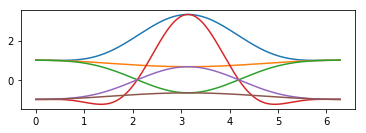

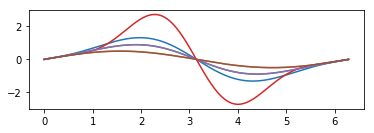

In [12]:
"""
  Plot of each composant in M (one by epsilon_i value)
"""
for fun in wenol.func_M:
  plt.figure(1)
  plt.subplot(211)
  plt.plot(data.phi,fun(data.phi).real)
  plt.figure(2)
  plt.subplot(212)
  plt.plot(data.phi,fun(data.phi).imag)
plt.show()

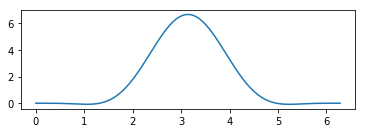

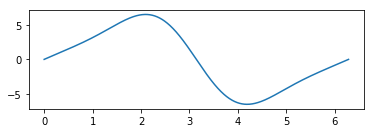

In [13]:
"""
  Plot of the sum of all composant of M (epsilon_i=1 for all i)
"""

M_sum = reim(sum(wenol.data_M))
plt.figure(1)
plt.subplot(211)
plt.plot(data.phi,M_sum[0])
plt.figure(2)
plt.subplot(212)
plt.plot(data.phi,M_sum[1])
plt.show()

La somme de toutes les composantes en $\epsilon_i$ est facilement majorable (il ne s'agit que d'une somme de cosinus et sinus). Wang et Spiteri majore ceci par $\Gamma\max_i|\epsilon_i|$, ce qu'ils retiennent surtout est la majoration par un truc qui est proportionnel à $\epsilon_i = \mathcal{O}(\Delta x^2)$.

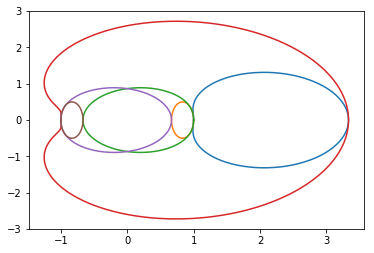

In [114]:
""" just because it's pretty: all composant of M in complex plan """
for dat in wenol.data_M:
  plt.plot(dat.real,dat.imag)
plt.show()

### 1.1.2 La partie linéaire $\tilde{z}$

$\tilde{z}$ est la partie linéaire de $\lambda^W(\phi)$ (c'est-à-dire ne dépendant pas des $\{\epsilon_j\}_{j\in[0,\cdots,5]}$. C'est la partie principale, la valeur exacte de $\lambda^W(\phi)$ peut être interprété comme la valeur de $\tilde{z} + \mathcal{O}(\Delta x^2)$.

Donc en prenant $\Delta x$ suffisamment petit, $\lambda^W(\phi) \xrightarrow{\Delta x \to 0} \tilde{z}(\phi)$.

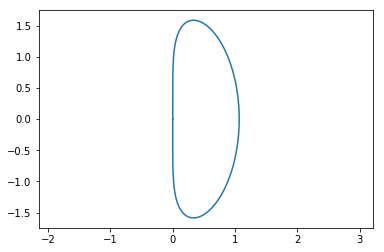

In [15]:
wenol.func_z = sp.lambdify(phi,ztilde_vN,'numpy')
wenol.data_z = wenol.func_z(data.phi)

plt.plot(*reim(wenol.data_z))
plt.axis('equal')
plt.show()

Le résultat est similaire à ce qui est présenté systématiquement comme la courbe de stabilité de la linéarisation du schéma WENO.

### Étude du schéma WENO linéarisé

Le schéma WENO linéarisé, qui correspond à l'approximation des poids à :

$$
    w_i = \gamma_i
$$

c'est-à-dire en considérant que les *indicators of smootheness* valent tous 1, ce qui se justifie avec une fonction suffisamment régulière.

On perd *a priori* l'intérêt du schéma WENO, il est donc intéressant d'étudier un peu plus ce schéma.

#### Mesure de l'ordre

On retrouve un ordre 5 comme le schéma WENO.

#### Comportement face à une discontinuité

#### Viscosité en temps long


## 1.2 WENO non linéarisé

Puisque j'effectue mes calculs à l'aide de `sympy` et qu'il est facilement d'écrire automatiquement une fonction de $\phi$ du schéma WENO complet, j'étudie l'analyse de von Neumann du schéma WENO complet non linéarisé.

In [16]:
"""
  complet WENO method
"""

epsilon = sp.symbols("\\epsilon",real=True,positive=True)

IS0 = sp.Rational(13,12)*( f(-2) - 2*f(-1) + f(+0) )**2 + sp.Rational(1,4)*( f(-2) - 4*f(-1) + 3*f(+0) )**2
IS1 = sp.Rational(13,12)*( f(-1) - 2*f(+0) + f(+1) )**2 + sp.Rational(1,4)*( f(-1) - f(+1) )**2
IS2 = sp.Rational(13,12)*( f(+0) - 2*f(+1) + f(+2) )**2 + sp.Rational(1,4)*( f(+2) - 4*f(+1) + 3*f(+0) )**2

a0 = sp.Rational(1,10)*(1/(epsilon+IS0))**2
a1 = sp.Rational(6,10)*(1/(epsilon+IS1))**2
a2 = sp.Rational(3,10)*(1/(epsilon+IS2))**2

s = a0 + a1 + a2
w0 = a0 / s
w1 = a1 / s
w2 = a2 / s

fjp12 = ( w0*( sp.Rational(2,6)*f(-2) - sp.Rational(7,6)*f(-1) + sp.Rational(11,6)*f(+0) )
        + w1*(-sp.Rational(1,6)*f(-1) + sp.Rational(5,6)*f(+0) +  sp.Rational(2,6)*f(+1) )
        + w2*( sp.Rational(2,6)*f(+0) + sp.Rational(5,6)*f(+1) -  sp.Rational(1,6)*f(+2) ) )
fjm12 = fjp12.subs(symbols_to(f_stencil, lambda j,_:f(j-1)),simultaneous=True)

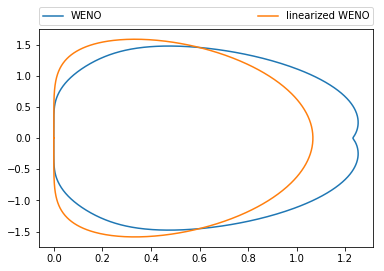

In [17]:
weno = Data()
weno.func = sp.lambdify(phi,(fjp12 - fjm12).subs(symbols_to_vonNeumann(f_stencil)).subs(epsilon,10**(-6)),'numpy')
weno.data = weno.func(data.phi)

plt.plot(*reim(weno.data),label="WENO")
plt.plot(*reim(wenol.data_z),label="linearized WENO")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102),loc=3,ncol=2, mode="expand",borderaxespad=0.)
plt.show()

On remarque une divergence dans les résultats. Une précédente étude avait montré que la CFL du couple RK3-WENO5 était atteinte à la base de l'*œuf* que forme la linéarisation du schéma WENO. La version non linéarisée étant moins large à la base, la CFL semble pouvoir être plus importante.

Il est intéressant à noter qu'un transport pur s'exprime avec l'axe imaginaire, la partie réelle traduit un phénomène de diffusion. On remarque que le schéma WENO linéarisé semble donc moins diffusif que sa version standard. Ceci s'explique par la construction du schéma WENO qui par le biais de ses poids, diffuse à l'approche d'une discontinuité au lieu d'osciller. Une étude envisageable est celle du schéma WENO linéarisé (ordre, comportement face à une discontinuité, etc.).

# 2. Schéma RK

Les schémas Runge-Kutta sont souvent utilisés dans le domaine des EDP pour résoudre la discrétisation en temps, conforme à cette tradition c'est ce que nous allons effectuer. Nous cherchons quel est l'ordre minimale $N$ pour stabiliser le couple RK$N$-WENO5, ou celui qui permettra d'obtenir la plus grande CFL avec le minimum de coût numérique.

On s'intéresse ici au polynôme caractéristique d'un schéma RK. On sait que le polynôme caractéristique d'un schéma RK$N$ est une troncature de la série entière de l'exponentielle (auquel peut s'ajouter des termes de degré plus élevé si le nombre d'étage $s$ est suppérieur à l'ordre de la méthode $N$), donc de la forme :

$$
  p_N(z) = \sum_{n=0}^N \frac{z^n}{n!}
$$

Il est ensuite nécessaire de tracer la courbe d'équation $|p_N(z)| = 1$, pour cela Miguel m'a proposé de résoudre dans un premier temps l'équation :

$$
  p_N(z) = e^{i\theta}
$$

à $\theta$ fixé, on a ainsi $N$ solutions $(b_0(\theta),\dots,b_N(\theta))$. Puis ensuite faire varier $\theta \in [0,2\pi[$. On obtient ainsi $N$ courbes paramétriques que l'on peut tracer sans trop de problèmes.

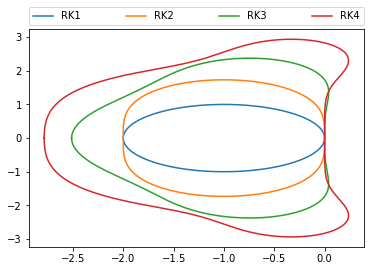

In [94]:
z = sp.symbols("z",complex=True)
theta = sp.symbols("\\theta",real=True)

import math

def poly_carac(N):
  return sum([ sp.Rational(1,(math.factorial(n)))*z**n for n in range(N+1) ])

def b(N):
  p = poly_carac(N)
  bset = sp.solveset(sp.Eq(p,sp.exp(I*theta)),z)
  
  bcurve = []
  for b in [ sp.lambdify(theta,b,'numpy') for b in bset ] :
    tmp = b(data.phi)
    bcurve.extend(tmp.tolist())
  return np.array(sorted(bcurve,key=lambda z:np.angle(z+1)))


b1 = b(1)
b2 = b(2)
b3 = b(3)
b4 = b(4)

plt.plot(*reim(b1),label="RK1")
plt.plot(*reim(b2),label="RK2")
plt.plot(*reim(b3),label="RK3")
plt.plot(*reim(b4),label="RK4")
#plt.xlim([-0.1,0.1])
#plt.axis('equal')
plt.legend(bbox_to_anchor=(0., 1.02, 1.,.102),loc=3,ncol=4,mode="expand",borderaxespad=0.)
plt.show()

## 2.1 Petit test en 3D

Il est relativement simple d'évaluer pour une série de point d'une grille la valeur de $|p_3(z_{j,k})|$ avec $z$ définit par :

$$
  z_{j,k} = j\Delta x + ik\Delta y
$$

Vu la facilité de la tâche il est relativement simple de répéter l'opération pour différents polynômes caractéristiques $p_N$. Le travail a été effectué pour $N=2,\dots,7$ (sans la moindre analyse des résultats, et avec une grille sans doute très mauvaise ainsi qu'un domaine qui ne permet pas de voir tout le domaine de RK7). On trace ainsi facilement :

$$
  \{z\in\mathbb{C},|p_N(z)| \leq 1\}
$$

Pour $N=3$, le cas qui nous intéresse, on obtient ainsi :

![Module de $p_3(z)$](rkdat/rk3.png)

Nous évaluons ici le polynôme en tous les points de la grille, la méthode n'est donc pas viable pour déterminer numériquement avec précision la frontière $|p_N(z)| = 1$ nécessaire dans l'estimation de la CFL $\sigma$.

## 2.2 Exploration pour les ordres supérieurs

Je n'arrive pas à trouver avec `sympy` par la même méthode RK5 (problème d'absence de formule analytique pour les racines pour les polynôme de degré supérieur ou égal à 5 ?). Pour obtenir l'ensemble :

$$
  b_5 = \{ z\in\mathbb{C},|p_5(z)| = 1 \}
$$

je dois explorer une autre méthode.

In [19]:
p5 = poly_carac(5)
theta = sp.symbols("\\theta",real=True)
theta = sp.Rational(2,100) # just test for a special value of theta
sp.Poly((p5-sp.exp(I*theta)).evalf(),z,domain="CC")

b5set = sp.solveset(p5-sp.exp(I*theta),z)
b5set

⎧                                          ⅈ     ⎫
⎪              5    4    3    2            ──    ⎪
⎨             z    z    z    z             50    ⎬
⎪z | z ∊ ℂ ∧ ─── + ── + ── + ── + z + 1 - ℯ   = 0⎪
⎩            120   24   6    2                   ⎭

La seule méthode qui me vient à l'esprit pour résoudre ce problème est de faire ça de manière purement numérique, de manière similaire au travail effectué en 3D. Cela nécessite sans doute une grille très fine (pour un meilleur résultat), en adaptant grossièrement le domaine d'étude en étudiant le polynôme dans $\mathbb{R}$ pour une première estimation du domaine à gauche. On estime que le domaine RKN est contenu vaguement dans un cercle, on obtient ainsi les estimations du domaine en haut et en bas, il n'y a que la limite à droite qu'il faut estimer par une autre méthode.

## 2.3 Polynôme caractérisitique pour d'autres méthodes

Le calcul effectué ne s'applique que pour un RK$N$ à $N$ étages. Considérons maintenant un RK$N$ à $s$ étages. Il est nécessaire de calculer son polynôme caractéristique à partir de son tableau de Butcher (pour le moment le travail n'est effectué qu'à partir de son écriture en $s$ étages).

> Il s'agit d'un travail préliminaire pour l'obtention de polynôme caractérisitque d'un IFRK (*integrating factor Runge-Kutta method*) qui est une famille de schémas introduisant une exponentielle pour résoudre une équation du type : $$
        \frac{\mathrm{d}u}{\mathrm{d}t} = Lu + N(u)
    $$

Pour obtenir un polynôme caractérisitique il est nécessaire de linéariser le problème en passant en complexe. Ainsi pour un problème du type :

$$
  \frac{\mathrm{d}u}{\mathrm{d}t} = L(u)
$$

on effectue la substitution :

* $L(u) \rightarrow \lambda u$ (on linéarise $L$ sur le plan complexe à l'aide d'une variable $\lambda$)
* $\lambda \Delta t \rightarrow z$ (on veut étudier le coefficient d'amplification donné par le produit $\lambda \Delta t$)

Nous étudions ainsi un schéma RK3 à 4 étages :

$$
  \begin{aligned}
    u^{(1)} &= u^n + \frac{1}{2}\Delta t L(u^n,t^n) \\
    u^{(2)} &= u^{(1)} + \frac{1}{2}\Delta t L(u^{(1)},t^n+\frac{1}{2}\Delta t) \\
    u^{(3)} &= \frac{2}{3}u^n + \frac{1}{3}u^{(2)} + \frac{1}{6}\Delta t L(u^{(2)},t^n+\Delta t) \\
    u^{n+1} &= u^{(3)} + \frac{1}{2}\Delta t L(u^{(3)},t^n+\frac{1}{2}\Delta t)
  \end{aligned}
$$

> Il est à noter qu'une méthode à $s$ étages donne un polynôme de degré $s$, par conséquent il n'est pas envisageable dans l'état actuel d'étudier des schémas en temps de degré supérieur à 4 pour les raisons expliqués sur la résolution de polynôme de degré 5.

In [81]:
un = sp.symbols("u_n")
dt = sp.symbols("\\Delta\\ t",real=True)
lamb = sp.symbols("\\lambda",complex=True)
z = sp.symbols("z",complex=True)

def L(u):
  return lamb*u

In [83]:
"""
Test de la procédure sur différents RK
RK3 Shu-Osher
"""
u1 = un + dt*L(un)
u2 = sp.Rational(3,4)*un + sp.Rational(1,4)*u1 + sp.Rational(1,4)*dt*L(u1)
un1 = sp.Rational(1,3)*un + sp.Rational(2,3)*u2 + sp.Rational(2,3)*dt*L(u2)

un1.subs(lamb*dt,z).expand().collect(un).collect(z)

   ⎛ 3    2        ⎞
   ⎜z    z         ⎟
uₙ⋅⎜── + ── + z + 1⎟
   ⎝6    2         ⎠

On retrouve bien le polynôme caractérisitique de SPPRK(3,3).

In [99]:
"""
RK3 à 4 étages
"""
u1 = un + sp.Rational(1,2)*dt*L(un)
u2 = u1 + sp.Rational(1,2)*dt*L(u1)
u3 = sp.Rational(2,3)*un + sp.Rational(1,3)*u2 + sp.Rational(1,6)*dt*L(u2)
un1 = u3 + sp.Rational(1,2)*dt*L(u3)

un1.subs(lamb*dt,z).expand().collect(un).collect(z)

   ⎛ 4    3    2        ⎞
   ⎜z    z    z         ⎟
uₙ⋅⎜── + ── + ── + z + 1⎟
   ⎝48   6    2         ⎠

Il est maintenant intéressant d'étudier le domaine de stabilité de ce schéma RK3 à 4 étages.

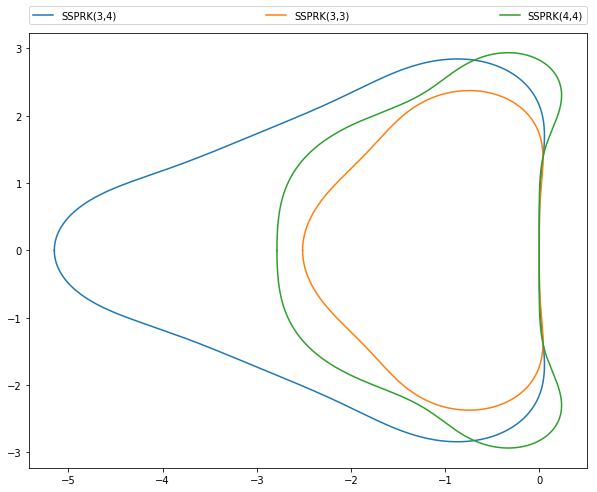

In [119]:
p = un1.subs(lamb*dt,z).expand().collect(un).collect(z)/un

def b_poly(p):
  bset = sp.solveset(sp.Eq(p,sp.exp(I*theta)),z)
  
  bcurve = []
  for b in [ sp.lambdify(theta,b,'numpy') for b in bset ] :
    tmp = b(data.phi)
    bcurve.extend(tmp.tolist())
  return np.array(sorted(bcurve,key=lambda z:np.angle(z+1)))

b34 = b_poly(p)
b3  = b_poly(poly_carac(3)) # juste pour exemple pour montrer que l'équivalence des fonctions

save_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(*reim(b34),label="SSPRK(3,4)")
plt.plot(*reim(b3),label="SSPRK(3,3)")
plt.plot(*reim(b4),label="SSPRK(4,4)")
plt.legend(bbox_to_anchor=(0., 1.02, 1.,.102),loc=3,ncol=3,mode="expand",borderaxespad=0.)
plt.show()
plt.rcParams['figure.figsize'] = save_figsize

Nicolas est intéressé par effectuer une étude un peu inverse, c'est-à-dire trouver le meilleur coefficient $\alpha$ tel que le polynôme caractéristique :

$$
  \alpha z^4 + \frac{z^3}{6} + \frac{z^2}{2} + z + 1
$$

ait le plus grand domaine de stabilité (en particulier sur l'axe imaginaire, pour exprimer la stabilité d'un schéma non diffusif). C'est à dire ajouter un étage sur une méthode RK3 existante, telle que celle-ci obtienne une meilleure stabilité.

56


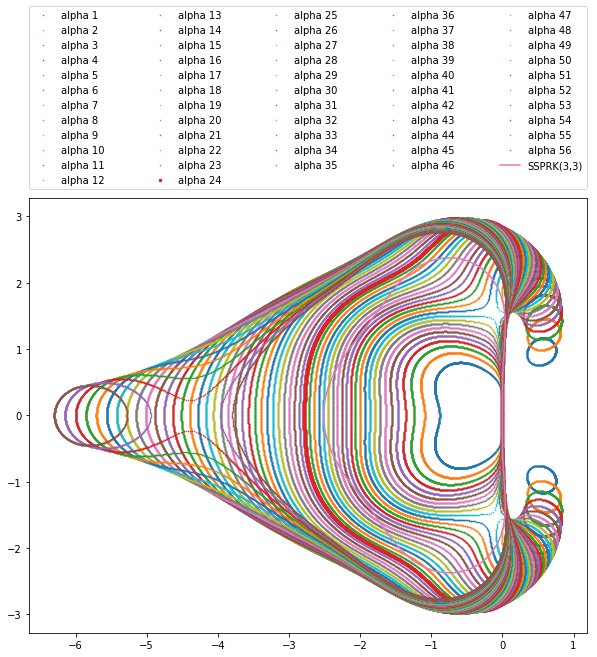

In [312]:
a = sp.symbols("\\alpha")
p = a*z**4 + poly_carac(3)

save_figsize = plt.rcParams['figure.figsize']
msize = 1
plt.rcParams['figure.figsize'] = [10, 8]
for n in range(1,57,1):
  print(n,end="\r")
  if n == 24 :
    msize = 5
  else:
    msize = 1
  bn = b_poly(p.subs(a,sp.Rational(1,n)))
  plt.plot(*reim(bn),'.',markersize=msize,label="alpha %i"%n)
print()
plt.plot(*reim(b3),label="SSPRK(3,3)")
plt.legend(bbox_to_anchor=(0., 1.02, 1.,.102),loc=3,ncol=5,mode="expand",borderaxespad=0.)
plt.show()
plt.rcParams['figure.figsize'] = save_figsize

Il s'agit là que d'une étude prospective, pour estimer la faisabilité à Nicolas d'une telle étude de manière quasi-automatisé. On semble remarquer que le schéma le plus *large* sur l'axe imaginaire correspond à RK4 (coefficient $\frac{1}{24}$ correspondant à la courbe en rouge un peu plus grasse).

14


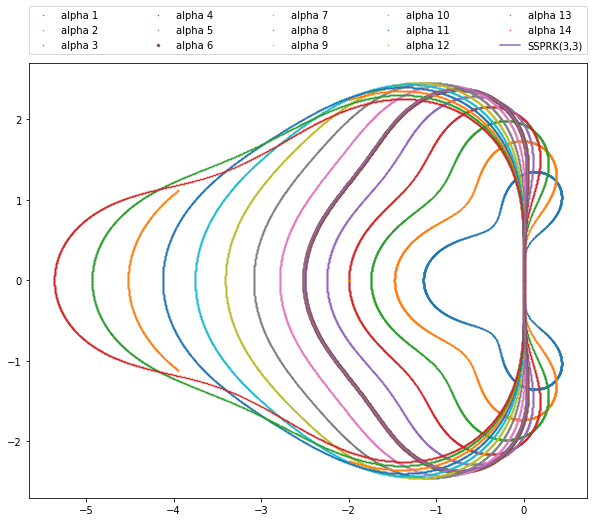

In [314]:
"""
  même étude pour RK2 à 3 étages
"""

a = sp.symbols("\\alpha")
p = a*z**3 + poly_carac(2)

save_figsize = plt.rcParams['figure.figsize']
msize = 1
plt.rcParams['figure.figsize'] = [10, 8]
for n in range(1,15,1):
  print(n,end="\r")
  if n == 6 :
    msize = 5
  else:
    msize = 1
  bn = b_poly(p.subs(a,sp.Rational(1,n)))
  plt.plot(*reim(bn),'.',markersize=msize,label="alpha %i"%n)
print()
plt.plot(*reim(b3),label="SSPRK(3,3)")
plt.legend(bbox_to_anchor=(0., 1.02, 1.,.102),loc=3,ncol=5,mode="expand",borderaxespad=0.)
plt.show()
plt.rcParams['figure.figsize'] = save_figsize

# 3. Étude de la stabilité du couple RK$N$-WENO5

On regarde maintenant la stabilité de WENO avec les différents schémas RK$N$. Pour cela on trace le domaine de stabilité du schéma RK choisi, et on compare ce domaine avec celui du coefficient d'amplification du schéma WENO5. Le schéma est linéariement stable s'il existe un coefficient $\sigma$, appelé CFL, permettant de faire *rentrer* la courbe du schéma WENO dans le domaine de stabilité de RK$N$.

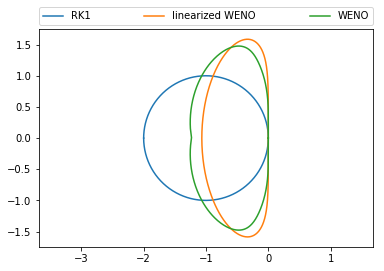

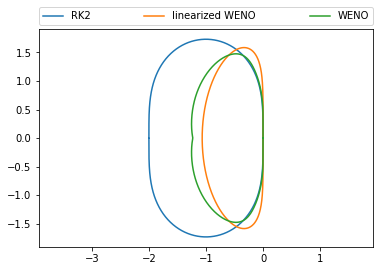

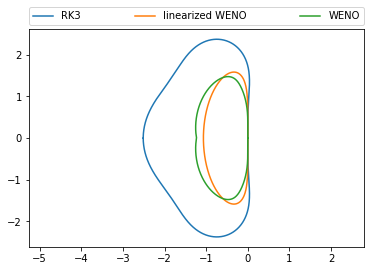

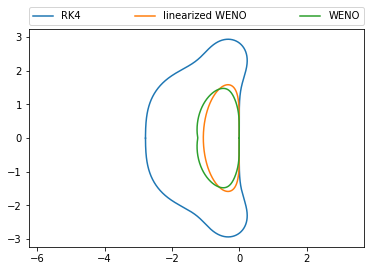

In [105]:
for (n,b) in enumerate((b1,b2,b3,b4),start=1):
  plt.plot(*reim(b),label="RK%i"%n)
  plt.plot(*reim(-wenol.data_z),label="linearized WENO")
  plt.plot(*reim(-weno.data),label="WENO")
  plt.axis('equal')
  plt.legend(bbox_to_anchor=(0., 1.02, 1.,.102),loc=3,ncol=3,mode="expand",borderaxespad=0.)
  plt.show()

## 3.1 Automatisation du calcul de CFL

Il est maintenant intéressant d'étudier quel est le rapport d'homothétie liant le mieux RK$N$ à WENO, ce rapport d'homothétie est $\sigma$ le nombre de CFL. Dans l'article [Wang R. and Spiteri R. J. (2007)](https://doi.org/10.1137/050637868) une approximation grossière est faite en supposant que RK$N$, pour $N\geq 3$ contient un rectangle contenant la courbe de WENO linéarisé. Une estimation est ainsi faite d'un $\sigma_0 \leq \sigma$. Il est possible dans un premier temps d'estimer numériquement un coefficient $\sigma_{\texttt{num}}$ tel que :

$$
  \sigma_0 \leq \sigma_{\texttt{num}} \leq \sigma
$$

travail effectué dans [Motamed M. and Macdonald C. B. (2010)](https://doi.org/10.1007/s10915-010-9423-9). Il est aussi possible de travailler sur la version complète du schéma WENO, en prenant en compte dans l'analyse de von Neumann de la partie non linéaire.

### 3.1.1 Estimation sur WENO linéarisé

Il est plus facile de travailler sur des tableaux des données du WENO et de RK$N$ de même dimension, et avec des données triées par argument (par rapport à l'estimation du rapport d'homotéthie).

In [21]:
def cfl( z_weno , b_rk ):
  zb = [ min(z_weno,key=lambda z:np.abs(np.angle(z)-np.angle(b_))) for b_ in b_rk ]
  sigs = [ np.abs((b_)/(z)) if np.abs(z)>1E-2 else float('nan') for (z,b_) in zip(zb,b_rk) ]
  plt.plot(data.phi,sigs)
  plt.xlabel("φ");plt.ylabel("σ")
  plt.show()
  return min(sigs)

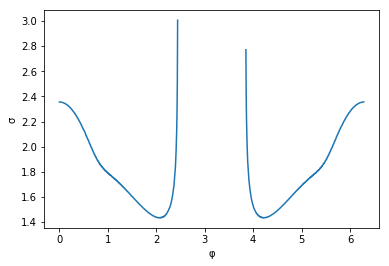

1.433683174288281

In [22]:
sigma_l = cfl(-wenol.data_z,b3[::3])
sigma_l

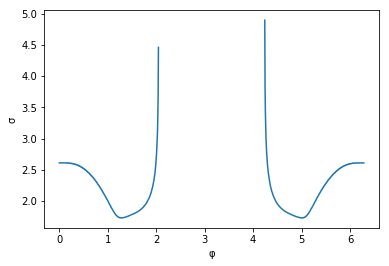

1.7311984792232984

In [106]:
cfl(-wenol.data_z,b4[::4])

### 3.1.2 Estimation sur WENO

On utilise maintenant la même fonction pour effectuer le même travail sur WENO complet.

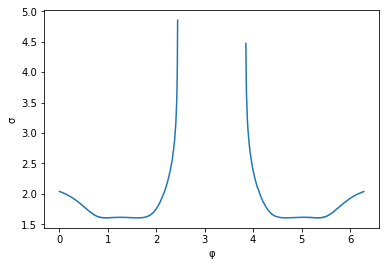

1.6064312370501719

In [24]:
sigma_w = cfl(-weno.data,b3[::3])
sigma_w

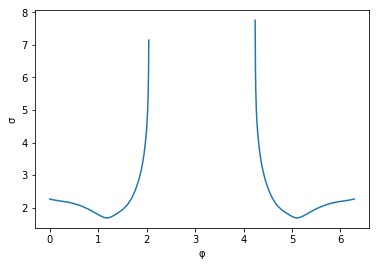

1.6805707317544747

In [79]:
cfl(-weno.data,b4[::4])

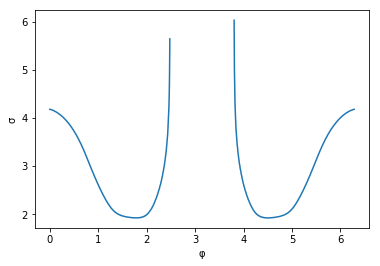

1.9235340506290004

In [108]:
sigma_w34 = cfl(-weno.data,b34[::4])
sigma_w34

On observe (ce qui est relativement étrange) une CFL plus faible dans le cas complet que linéarisé pour le couple RK4-WENO5.

### 3.1.3 Validation des CFL

On s'intéresse ici à regarder où s'effectue la contrainte de la CFL. Il peut être intéressant numériquement d'exciter le mode particulier avec le bon $\Delta x$ qui stabilise ou non le schéma.

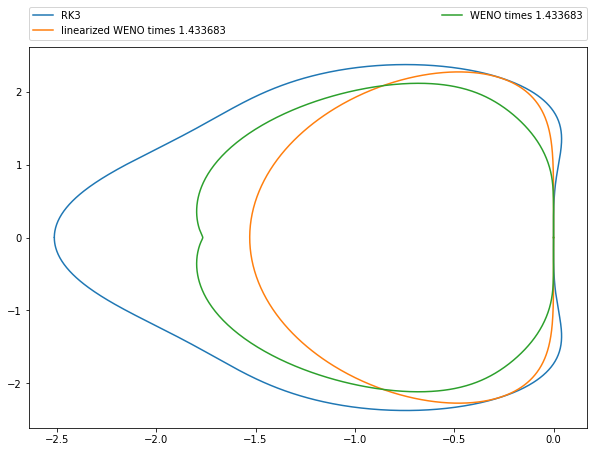

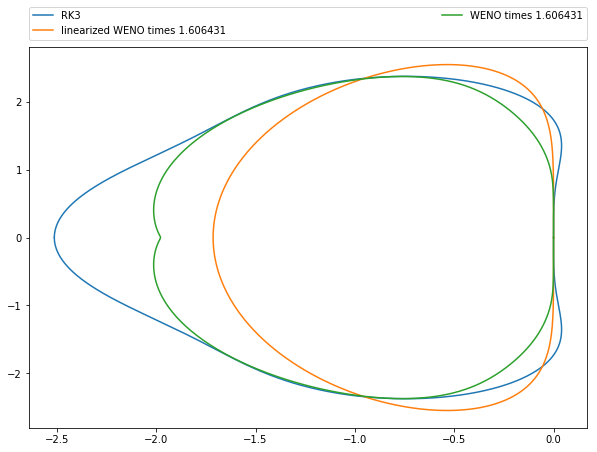

In [95]:
tmp = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [10, 7]

b_rk = b3[::3]; n=3
plt.plot(*reim(b_rk[:]),label="RK%i"%n)
plt.plot(*reim(-sigma_l*wenol.data_z[:]),label="linearized WENO times %f"%sigma_l)
plt.plot(*reim(-sigma_l*weno.data[:]),label="WENO times %f"%sigma_l)
#plt.axis('equal')
plt.legend(bbox_to_anchor=(0., 1.02, 1.,.102),loc=3,ncol=2,mode="expand",borderaxespad=0.)
plt.show()

plt.plot(*reim(b_rk[:]),label="RK%i"%n)
plt.plot(*reim(-sigma_w*wenol.data_z[:]),label="linearized WENO times %f"%sigma_w)
plt.plot(*reim(-sigma_w*weno.data[:]),label="WENO times %f"%sigma_w)
#plt.axis('equal')
plt.legend(bbox_to_anchor=(0., 1.02, 1.,.102),loc=3,ncol=2,mode="expand",borderaxespad=0.)
plt.show()

(data.phi[300],np.angle(wenol.data_z[300]),wenol.data_z)

plt.rcParams['figure.figsize'] = tmp

On effectue maintenant un zoom dans le cas de la CFL `sigma_w`.

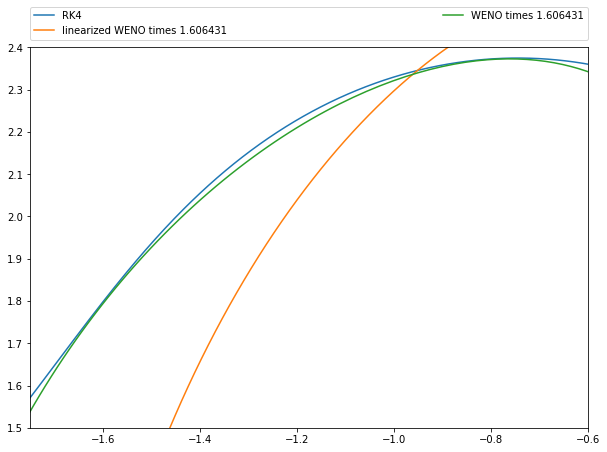

In [109]:
tmp = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [10, 7] # default:[6,4]

plt.plot(*reim(b3),label="RK%i"%n)
plt.plot(*reim(-sigma_w*wenol.data_z),label="linearized WENO times %f"%sigma_w)
plt.plot(*reim(-sigma_w*weno.data),label="WENO times %f"%sigma_w)
plt.xlim([-1.75,-0.6])
plt.ylim([1.5,2.4])
plt.legend(bbox_to_anchor=(0., 1.02, 1.,.102),loc=3,ncol=2,mode="expand",borderaxespad=0.)
plt.show()

plt.rcParams['figure.figsize'] = tmp

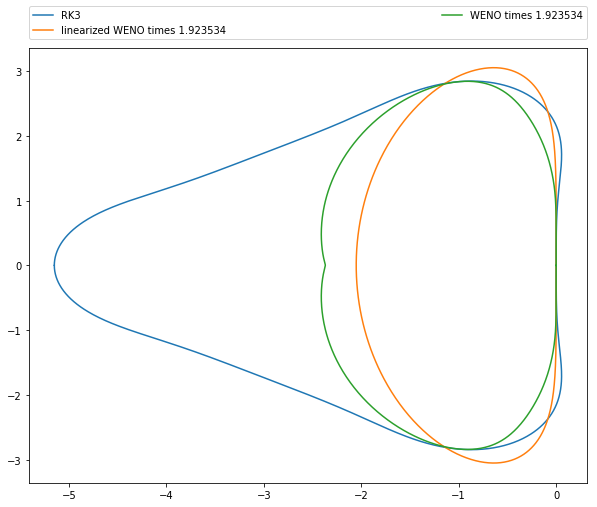

In [315]:
"""
  Stability of SSPRK(3,4)-WENO5 with a CFL of 1.923 with the computation time than RK4 (and a "bad" CFL)
"""

tmp = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [10, 8]

b_rk = b34[::4]; n=3
plt.plot(*reim(b_rk[:]),label="RK%i"%n)
plt.plot(*reim(-sigma_w34*wenol.data_z[:]),label="linearized WENO times %f"%sigma_w34)
plt.plot(*reim(-sigma_w34*weno.data[:]),label="WENO times %f"%sigma_w34)
#plt.axis('equal')
plt.legend(bbox_to_anchor=(0., 1.02, 1.,.102),loc=3,ncol=2,mode="expand",borderaxespad=0.)
plt.show()

plt.rcParams['figure.figsize'] = tmp

## 3.2 Validation par simulation numérique

Il est mainenant nécessaire de tester en différents points du domaine et de tester la validité des dires sur la CFL. Pour s'assurer que l'on excite qu'un seul mode il est nécessaire d'effectuer le transport d'un cosinus avec un mode $\xi$ et un $\Delta x$ vérifiant :

$$
  \phi = 2\pi\xi\Delta x
$$

> **Petite note pour Paul:** puisque je fais du numérique je prends $\xi=2$ c'est très bien, et je ne travaille pas sur des schémas capables de gérer des modes élevé comme Joackim avec son mode 41 ^^

On prendra le mode d'excitation $\xi=2$ par conséquent pour un $\phi$ donné on calcul un $\Delta x$ :

$$
  \Delta x = \frac{\phi}{4\pi}
$$

Nous fixons la CFL $\sigma^{W_{NL}} \approx 1.606$ tel que donné par l'étude de CFL du couple WENO non linéarisé avec RK3. L'angle $\phi$ est choisi en prenant l'argument d'un point sur la courbe $\tilde{z}$ (donc un coefficient d'amplification du WENO linéarisé) tel qu'il soit en dehors du domaine de stabilité de RK3. Numériquement nous prendrons : $\phi = 1.38337934$.

Nous effectuons une simulation de :

$$
  \begin{cases}
    \partial_t u + \partial_x u = 0 \\
    u^0 = \cos(2 x)
  \end{cases}
$$

sur le domaine spatiale $[0,2\pi]$, jusqu'au temps final $T_f = 15$. Nous prendrons comme nombre de CFL $\sigma^{W_{NL}} \approx 1.606$.

|         step          |         value         |
|-----------------------|-----------------------|
| $\Delta x$            | `0.11008583006610187` |
| $\Delta t$            | `0.15742273699452566` |

La simulation s'effectuons donc avec $N=57$ points.

![Simulation du schéma WENO avec une CFL à 1.606](translate/translate_Wnlsnl.png)

Nous constatons une stabilité du schéma WENO5-RK3, malgré quelques oscillations, celles-ci ne divergent pas même en temps longs, le schéma est malheureusement très diffusif sous ces conditions. Ces oscillations s'estompent dès que le contraint moins la CFL, en prenant par exemple pour CFL $\sigma^{W_L} \approx 1.433$ on obtient :

![Simulation du schéma WENO avec une CFL à 1.433](translate/translate_Wnlsl.png)

ce qui laisse sous entendre que le coefficient d'amplification du schéma WENO est bien donné par la courbe verte. De plus en prenant une CFL légèrement suppérieur ($\approx 1.7$) le schéma est instable.

Un test avec un schéma WENO linéarisé, c'est-à-dire avec des poids $w_i = \gamma_i$ est aussi effectué. On remarque qu'il est alors nécessaire de conserver la CFL à $\sigma^{W_L} \approx 1.433$ pour stabiliser le schéma.

![Simulation du schéma WENO linéarisé avec une CFL à 1.606](translate/translate_Wlsnl.png)
![Simulation du schéma WENO linéarisé avec une CFL à 1.433](translate/translate_Wlsl.png)

Cela semble confirmer le calcul de CFL pour le WENO complet.